In [29]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
!nvidia-smi

BATCH = 2048

Wed Jun 15 13:26:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:1A:00.0 Off |                  Off |
| 30%   29C    P8    23W / 230W |      8MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:67:00.0 Off |                  Off |
| 30%   

In [30]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import torch.backends.cudnn as cudnn

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"

print_freq = 50

K = 4

In [31]:
train_df = pd.read_csv("trainLabels.csv")
train_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
train_df.head()

,id,label,label_enc
0,1,frog,6
1,2,truck,9
2,3,truck,9
3,4,deer,4
4,5,automobile,1


In [33]:
# 5-flod
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


# prepare dataset

In [34]:
mixup = False

class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
        
        # Mixup part
        """
        rd = torch.rand(1)
        label2 = label
        gamma = np.array(np.ones(1)).astype(np.float32)[0]
        if mixup and rd < 0.3 and self.transform is not None and not self.test:
            mix_idx = np.random.random_integers(0, len(self.df))
            row2 = self.df.iloc[mix_idx]
            img_id2 = row2.id
            images2 = cv2.imread(os.path.join(DATA_DIR, str(img_id2)+".png"))
            
            if self.transform is not None:
                images2 = self.transform(image=images2)['image']
            
            # blend image
            gamma = np.array(np.random.beta(1,1)).astype(np.float32)
            images = ((images*gamma + images2*(1-gamma))).astype(np.uint8)
            # blend labels
            label2 = row2.label_enc
        """
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [35]:
import albumentations as A
import albumentations

imsize = 32
transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.25),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.25),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.RandomCrop(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


show imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

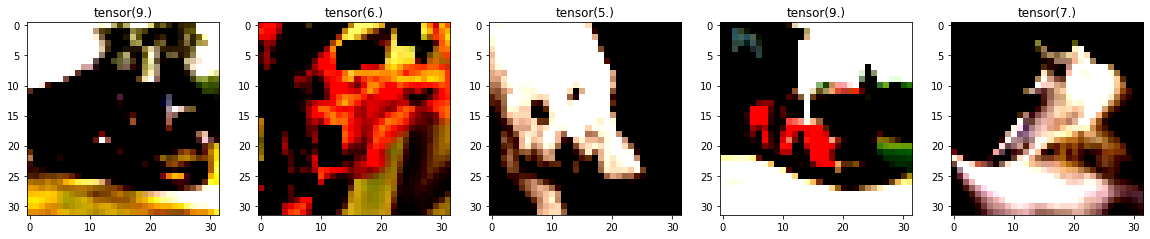

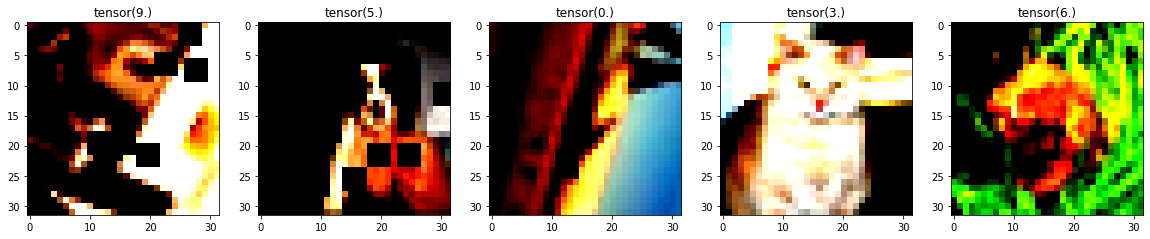

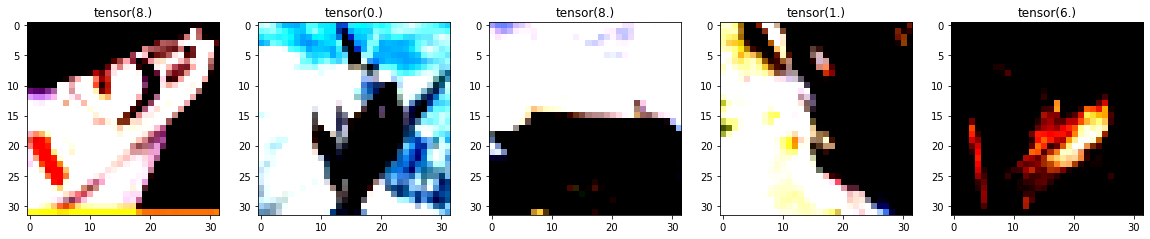

In [36]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))

# Trainer

In [37]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [38]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.0002
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Train loop

In [39]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH*2, shuffle=False,
    num_workers=4, pin_memory=True)

In [40]:
for K in range(3,8):
    model = resnet.__dict__["resnet20"](K)
    model = model.cuda()

    model = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

    import wandb
    watermark = "resnet20_paper_quant{}".format(K)
    wandb.init(project="pact_cim",
                name=watermark)

    # define loss function (criterion) and pptimizer
    mixup = False
    criterion = nn.CrossEntropyLoss().cuda()

    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1,
                                momentum=0.9,
                                weight_decay=0.0002)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                        milestones=[80, 150],)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(200):
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/resnet20_paper_quant{K}.pth'))

bit width: 3


epoch,▁
lr,▁
prec,▁
train_loss,▁
val_loss,▁
epoch,0
lr,0.1
prec,15.94
train_loss,4.3005
val_loss,2.22726


current lr 1.00000e-01
Epoch: [0][0/20]	Time 8.102 (8.102)	Data 1.487 (1.487)	Loss 7.1888 (7.1888)	Prec@1 9.277 (9.277)
Test: [0/3]	Time 3.614 (3.614)	Loss 58.9398 (58.9398)	Prec@1 14.355 (14.355)
 * Prec@1 13.780
module.alpha1 9.927702903747559
module.layer1.0.alpha1 9.927597999572754
module.layer1.0.alpha2 9.940302848815918
module.layer1.1.alpha1 9.927586555480957
module.layer1.1.alpha2 10.144759178161621
module.layer2.0.alpha1 9.927571296691895
module.layer2.0.alpha2 10.028341293334961
module.layer2.1.alpha1 9.927658081054688
module.layer2.1.alpha2 10.573185920715332
module.layer3.0.alpha1 9.9276123046875
module.layer3.0.alpha2 10.15453052520752
module.layer3.1.alpha1 9.928187370300293
module.layer3.1.alpha2 11.659173965454102
module.layer4.0.alpha1 9.928364753723145
module.layer4.0.alpha2 10.13070011138916
module.layer4.1.alpha1 9.953115463256836
module.layer4.1.alpha2 9.346686363220215
Best prec1 :  13.779999954223634
current lr 1.00000e-01
Epoch: [1][0/20]	Time 1.896 (1.896)	Data

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
prec,▁▁▂▂▃▃▄▄▄▄▅▆▆▆▇▇████████████████████████
train_loss,█▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▅▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,0.001
prec,75.89
train_loss,0.85688
val_loss,0.69602


current lr 1.00000e-01
Epoch: [0][0/20]	Time 1.916 (1.916)	Data 1.618 (1.618)	Loss 9.1444 (9.1444)	Prec@1 10.498 (10.498)
Test: [0/3]	Time 1.950 (1.950)	Loss 11.2249 (11.2249)	Prec@1 18.945 (18.945)
 * Prec@1 18.350
module.alpha1 9.927470207214355
module.layer1.0.alpha1 9.92811107635498
module.layer1.0.alpha2 9.950128555297852
module.layer1.1.alpha1 9.928736686706543
module.layer1.1.alpha2 10.35322380065918
module.layer2.0.alpha1 9.92772388458252
module.layer2.0.alpha2 10.146586418151855
module.layer2.1.alpha1 9.930183410644531
module.layer2.1.alpha2 11.384992599487305
module.layer3.0.alpha1 9.936426162719727
module.layer3.0.alpha2 10.471116065979004
module.layer3.1.alpha1 9.94082260131836
module.layer3.1.alpha2 12.362387657165527
module.layer4.0.alpha1 9.94947624206543
module.layer4.0.alpha2 10.415520668029785
module.layer4.1.alpha1 10.071014404296875
module.layer4.1.alpha2 8.34849739074707
Best prec1 :  18.349999887084962
current lr 1.00000e-01
Epoch: [1][0/20]	Time 1.792 (1.792)	Dat

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
prec,▁▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇████████████████████████
train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,0.001
prec,80.55
train_loss,0.6112
val_loss,0.56249


current lr 1.00000e-01
Epoch: [0][0/20]	Time 1.821 (1.821)	Data 1.536 (1.536)	Loss 8.2825 (8.2825)	Prec@1 8.984 (8.984)
Test: [0/3]	Time 1.963 (1.963)	Loss 122.7347 (122.7347)	Prec@1 11.011 (11.011)
 * Prec@1 11.540
module.alpha1 9.92765998840332
module.layer1.0.alpha1 9.924860954284668
module.layer1.0.alpha2 9.954946517944336
module.layer1.1.alpha1 9.92844009399414
module.layer1.1.alpha2 10.293335914611816
module.layer2.0.alpha1 9.945958137512207
module.layer2.0.alpha2 10.260394096374512
module.layer2.1.alpha1 9.975859642028809
module.layer2.1.alpha2 11.302938461303711
module.layer3.0.alpha1 9.972494125366211
module.layer3.0.alpha2 10.786956787109375
module.layer3.1.alpha1 10.007001876831055
module.layer3.1.alpha2 12.518058776855469
module.layer4.0.alpha1 10.06266975402832
module.layer4.0.alpha2 10.565590858459473
module.layer4.1.alpha1 10.215575218200684
module.layer4.1.alpha2 7.942868709564209
Best prec1 :  11.53999995880127
current lr 1.00000e-01
Epoch: [1][0/20]	Time 1.761 (1.761)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
prec,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇████████████████████████
train_loss,█▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▄▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,0.001
prec,79.46
train_loss,0.52542
val_loss,0.63494


current lr 1.00000e-01
Epoch: [0][0/20]	Time 1.746 (1.746)	Data 1.452 (1.452)	Loss 6.3622 (6.3622)	Prec@1 10.791 (10.791)
Test: [0/3]	Time 1.956 (1.956)	Loss 64.8895 (64.8895)	Prec@1 9.814 (9.814)
 * Prec@1 9.720
module.alpha1 9.927687644958496
module.layer1.0.alpha1 9.927727699279785
module.layer1.0.alpha2 9.936817169189453
module.layer1.1.alpha1 9.930697441101074
module.layer1.1.alpha2 10.326315879821777
module.layer2.0.alpha1 9.932943344116211
module.layer2.0.alpha2 10.10568618774414
module.layer2.1.alpha1 9.968518257141113
module.layer2.1.alpha2 11.54609203338623
module.layer3.0.alpha1 9.95470142364502
module.layer3.0.alpha2 10.626596450805664
module.layer3.1.alpha1 9.979344367980957
module.layer3.1.alpha2 12.851627349853516
module.layer4.0.alpha1 10.00329875946045
module.layer4.0.alpha2 10.328205108642578
module.layer4.1.alpha1 10.18980884552002
module.layer4.1.alpha2 8.675976753234863
Best prec1 :  9.719999987792969
current lr 1.00000e-01
Epoch: [1][0/20]	Time 1.798 (1.798)	Data 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
prec,▁▁▂▂▃▃▄▅▅▆▆▆▇▇▇▇████████████████████████
train_loss,█▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,0.001
prec,77.17
train_loss,0.66041
val_loss,0.67506


current lr 1.00000e-01
Epoch: [0][0/20]	Time 1.815 (1.815)	Data 1.531 (1.531)	Loss 12.3773 (12.3773)	Prec@1 10.059 (10.059)
Test: [0/3]	Time 2.135 (2.135)	Loss 8.9729 (8.9729)	Prec@1 10.718 (10.718)
 * Prec@1 10.450
module.alpha1 9.927488327026367
module.layer1.0.alpha1 9.92809772491455
module.layer1.0.alpha2 9.960092544555664
module.layer1.1.alpha1 9.938742637634277
module.layer1.1.alpha2 10.490890502929688
module.layer2.0.alpha1 9.929146766662598
module.layer2.0.alpha2 10.20030403137207
module.layer2.1.alpha1 9.940842628479004
module.layer2.1.alpha2 11.252776145935059
module.layer3.0.alpha1 9.943678855895996
module.layer3.0.alpha2 10.50536823272705
module.layer3.1.alpha1 9.96088981628418
module.layer3.1.alpha2 11.82783031463623
module.layer4.0.alpha1 9.973917007446289
module.layer4.0.alpha2 10.510127067565918
module.layer4.1.alpha1 10.090267181396484
module.layer4.1.alpha2 7.340924263000488
Best prec1 :  10.450000080871582
current lr 1.00000e-01
Epoch: [1][0/20]	Time 1.754 (1.754)	Da

In [41]:
arch = "resnet34"

for K in range(3,8):
    model = resnet.__dict__[arch](K)
    model = model.cuda()

    model = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

    import wandb
    watermark = "{}_paper_quant{}".format(arch,K)
    wandb.init(project="pact_cim",
                name=watermark)

    # define loss function (criterion) and pptimizer
    mixup = False
    criterion = nn.CrossEntropyLoss().cuda()
    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1,
                                momentum=0.9,
                                weight_decay=0.0002)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                        milestones=[80, 150],)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(200):
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{arch}_paper_quant{K}.pth'))

bit width: 3


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
prec,▁▂▃▄▅▅▆▆▇▇▇▇▇▇██████████████████████████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,0.001
prec,80.67
train_loss,0.42313
val_loss,0.61132


current lr 1.00000e-01
Epoch: [0][0/20]	Time 2.078 (2.078)	Data 1.536 (1.536)	Loss 6.5578 (6.5578)	Prec@1 9.180 (9.180)
Test: [0/3]	Time 2.077 (2.077)	Loss 11.3476 (11.3476)	Prec@1 10.059 (10.059)
 * Prec@1 10.080
module.alpha1 9.92750072479248
module.layer1.0.alpha1 9.927831649780273
module.layer1.0.alpha2 9.9331693649292
module.layer1.1.alpha1 9.927964210510254
module.layer1.1.alpha2 9.956912994384766
module.layer1.2.alpha1 9.927531242370605
module.layer1.2.alpha2 10.040024757385254
module.layer2.0.alpha1 9.927566528320312
module.layer2.0.alpha2 9.940276145935059
module.layer2.1.alpha1 9.927542686462402
module.layer2.1.alpha2 9.979959487915039
module.layer2.2.alpha1 9.927573204040527
module.layer2.2.alpha2 9.993932723999023
module.layer2.3.alpha1 9.927568435668945
module.layer2.3.alpha2 10.242972373962402
module.layer3.0.alpha1 9.927568435668945
module.layer3.0.alpha2 9.937416076660156
module.layer3.1.alpha1 9.92758560180664
module.layer3.1.alpha2 9.98436164855957
module.layer3.2.alp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
prec,▁▁▁▁▂▃▃▃▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,██▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▆▆▆▆▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,0.001
prec,65.23
train_loss,1.18662
val_loss,0.97664


current lr 1.00000e-01
Epoch: [0][0/20]	Time 1.978 (1.978)	Data 1.483 (1.483)	Loss 7.6151 (7.6151)	Prec@1 10.205 (10.205)
Test: [0/3]	Time 2.093 (2.093)	Loss 45.6059 (45.6059)	Prec@1 13.306 (13.306)
 * Prec@1 13.270
module.alpha1 9.927828788757324
module.layer1.0.alpha1 9.927677154541016
module.layer1.0.alpha2 9.929646492004395
module.layer1.1.alpha1 9.927062034606934
module.layer1.1.alpha2 9.969158172607422
module.layer1.2.alpha1 9.926897048950195
module.layer1.2.alpha2 10.122509002685547
module.layer2.0.alpha1 9.927563667297363
module.layer2.0.alpha2 10.026062965393066
module.layer2.1.alpha1 9.92894172668457
module.layer2.1.alpha2 10.241288185119629
module.layer2.2.alpha1 9.927874565124512
module.layer2.2.alpha2 10.4061279296875
module.layer2.3.alpha1 9.928879737854004
module.layer2.3.alpha2 11.32575511932373
module.layer3.0.alpha1 9.93080997467041
module.layer3.0.alpha2 10.270761489868164
module.layer3.1.alpha1 9.955368995666504
module.layer3.1.alpha2 10.46982479095459
module.layer3